# Classification

## Setup

In [24]:
# Python >= 3.5 nécessaire
import sys
assert sys.version_info >= (3, 5)
import pandas as pd

# Scikit-Learn >= 0.20 nécessaire
import sklearn
assert sklearn.__version__ >= "0.20"

# Autres imports
import numpy as np
import os

# pour rendre les sorties du notebook stable au cours des différents runs
np.random.seed(42)

# Pour faire de jolies figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# où sauvegarder les figures
PROJECT_ROOT_DIR = ".."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


## MNIST

Pour ce chapitre, nous allons utiliser le jeu de données MNIST qui est un set de 70000 petites images de chiffres écrits à la main. Chaque image est labellisée avec son chiffre.

*Scikit-Learn* fournit de nombreuses fonctions d'aides pour télécharger des JdD populaires, dont MNIST. Le code suivant va chercher le JdD :

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Les JdD chargés par *Scikit-Learn* ont généralement une structure dictionnaire similaire, comprenant :
- une clé `DESCR`, qui décrit le JdD
- Une clé `data` contenant un tableau avec une ligne par instance et une colonne par caractéristique (*feature*)
- Une clé `target` contenant un tableau avec les labels

Regardons ces tableaux :

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

Il y a 70000 images, et chaque image a 784 caractéristiques, car chaque image fait $28*28$ pixels, et chaque caractéristique représente l'intensité d'un pixel (0 : blanc, 255 : noir).

Regardons un chiffre du JdD. Tout ce dont on a besoin est de prendre un vecteur d'une caractéristique d'une instance, le mettre en tableau $28*28$ et l'afficher en utilisant la fonction `imshow()` de Matplotlib :

Saving figure some_digit_plot


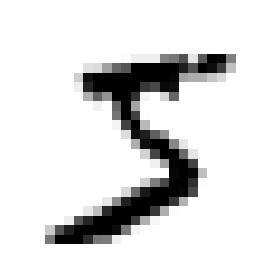

In [25]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Dans le livre : some_digit = [0]
# Cette syntaxe ne fonctionne pas pour extraire en tant que tableau la ligne 0 d'un DataFrame pandas
# J'ai donc utilisé la méthode un peu bourrin juste en dessous
some_digit = X.iloc[0].to_numpy()
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [6]:
y[0]

'5'

Le label est un `string`, donc il faut le *cast* en `integer` :

In [8]:
y = y.astype(np.uint8)
y[0]

5

Le JdD MNIST est déjà découpé avec son JdE (les 60000 premières images) et son JdT (les dernières 10000 images):

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Le JdE a déjà été mélangé, ce qui est une bonne chose puisque cela nous garanti que les blocs (*folds*) de validation croisée seront similaires (on ne voudrait pas qu'un bloc ne dispose pas d'un type de chiffre). De plus, certains algo d'apprentissage son sensibles à l'ordre d'entraînement des instacnes, et ont de mauvaises performances s'ils ont plusieurs instances similaires dans une ligne. Mélanger (*shuffle*) le JdD assure que cela n'arrive pas.

## Entraîner un classificateur binaire (*binary classification*)

On va simplifier le problème pour l'instant, et essayer de n'identifier qu'un seul chiffre : le 5.
Ce détecteur de 5 sera un classificateur binaire, capable de distinguer deux classes uniquement : "5" et "pas 5".

On crée le vecteur cible pour cette tâche de classification :

In [18]:
y_train_5 = (y_train == 5) # True pour tous les 5, False pour tous les autres chiffres
y_test_5 = (y_test == 5)

Maintenant, on va choisir un classificateur et l'entraîner.

Un bon point de départ est le classificateur *Stochastic Gradient Descent* (`SGD` - Gradient de descente stochastique), qu'on peut utiliser avec la classe *Scikit-Learn* `SGDClassifier`. Il a l'avantage d'être **capable de gérer de très grand JdD efficacement**. C'est en parti dû au fait que SGD **gère les instances d'entraînement indépendemment, une à la fois** (ce qui le rend également **adapté au _online learning_**).

On va créer un classificateur `SGDClassifier` et l'entraîner avec tout je JdE :

In [19]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
# Si on veut des résultats reproductibles, il faut définir le paramètre random_state
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

On va maintenant l'utiliser pour détecter les images du chiffre 5 :µ

In [20]:
sgd_clf.predict([some_digit])

/home/remycosta/.local/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

Un message d'erreur inattendu suite à la conversion des données, c'est gênant, mais au final on le bon résultat puisqu'il a détecté que notre image représente un 5.

## Mesures de performances

Évaluer un classificateur est souvent beaucoup plus complexe qu'évaluer un régresseur (*regressor*), donc on va passer un certain temps là dessus.
Il y a beaucoup de mesures de performances disponibles, donc attention aux nouveaux concepts et acronymes.

### Mesurer la précision avec la validation croisée

Comme dans le chapitre 2, la validation croisée est une bonne manière d'évaluer un modèle

#### Implémenter la validation croisée

Parfois, on va avoir besoin de plus de contrôle sur le processus de validation croisée que ce que *Scikit-Learn* fournit à la volée. Le code suivant fait globalement la même chose que la fonction `cross_val_score()`, et print le même résultat :

In [29]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

KeyError: "None of [Int64Index([    1,     3,     4,     5,     7,     8,    10,    11,    12,\n               13,\n            ...\n            59984, 59985, 59987, 59988, 59989, 59991, 59993, 59994, 59996,\n            59998],\n           dtype='int64', length=40000)] are in the [columns]"

On a donc encore un truc qui ne marche pas ici, et ça a l'air plutôt compliqué de régler le problème, donc on va essayer la suite.

On va maintenant utiliser la fonction `cross_val_score()` pour évaluer notre modèle `SGDClassifier`, en utilisant une validation croisée à K-blocs, avec 3 blocs. On rappelle que la validation croisée en K-blocs divise le JdE en K blocs et fait ensuite des prédictions et les évalue sur chaque bloc en utilisant un modèle entraîné sur les autres blocs.

In [30]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

On obtient des résultats très intéressants, avec plus de 95% de précision. Avant de s'emballer, on va regarder un autre type de classificateur débile qui se contente juste de classifier chaque image dans la classe "pas 5" :

In [31]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

Observons la précision de ce modèle :

In [32]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

90% de précision : c'est simplement parce qu'environ 10% des images sont des 5, donc si on devine à chaque fois qu'une image n'est pas 5, on aura raison 90% du temps.

Cet exemple était pour montrer que la précision n'est généralement pas la mesure de performance préférée pour les classificateurs, particulièrement quand on travaille avec des JdD biaisés qui ont des classes beaucoup plus fréquentes que d'autres (*skewed datasets*).

### Matrice de confusion (*confusion matrix*)

Une bien meilleure manière d'évaluer la performance d'un classificateur est de regarder sa *matrice de confusion*. L'idée générale est de compter le nombre de fois que les instances d'une classe A sont classifiée comme classe B. Par exemple, pour connaître le nombre de fois qu'un classificateur a confondu les images de 5 avec des images de 3, on pourrait regarder dans la cinquième ligne, troisième colonne de la matrice de confusion.

Pour calculer la matrice de confusion, on a d'abord besoin d'un *jeu de prédictions qui peuvent être comparées au cibles (*targets*) réelles. On pourrait faire des prédictions sur le JdT, mais il vaut mieux le laisser intouché (rappel : on ne l'utilise qu'à la toute fin du projet, une fois qu'on a un classificateur prêt à être déployé).

À la place, on peut utiliser la fonction `cross_val_predict` :

In [33]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Comme la fonction cross_val_score, la fonction cross_val_predict va faire une validation croisée à k-blocs, mais au lieu de retourner le score d'évaluation, il va retourner les prédictions faites sur chaque bloc de test. Cela signifie qu'on va avoir une prédiction propre pour chaque instance dans le JdE ("propre" signifie que la prédiction est faire par un modèle qui n'a jamais vu les données durant l'entraînement).

On peut maintenant avoir la matrice de confusion, en utilisant la fonction `confusion_matrix()`. Il y a simplement besoin de lui passer les classes des cibles (*y_train_5*), et les classes des prédictions (*y_train_pred*) :

In [34]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Chaque ligne dans une matric de confusion représente *une vraie classe*, tandis que chaque colonne représente une *classe prédite*. La première ligne de cette matrice prend en considération les images "non 5" (la classe *négative*) : 53892 d'entre elles ont été correctement classifées en tant que "non 5" (**vrai négatifs**), tandis que les 687 restant ont été faussement claissifée en tant que 5 (**faux positif**). La seconde ligne prend en considération les images "5" : 1891  ont été faussement classifiées en tant que "non 5" (**faux négatif**), alors que 3530 ont été correctement classifées en tant que "5" (**vrai positif**). Un classificateur parfait n'aurait que des vrais positifs et des vrais négatifs, et donc la matrice de confusion n'aurait que des 0 dans sa diagonale principale (bas gauche, haut droit) :

In [35]:
y_train_prefect_predictions = y_train_5 # on prétend avoir atteint la perfection
confusion_matrix(y_train_5, y_train_prefect_predictions)

array([[54579,     0],
       [    0,  5421]])

La matrice de confusion donne beaucoup d'informations, mais il est parfois préférable d'avoir des mesures précises. Une mesure intéressante à regarder est la précision des prédictions positives, appeléé `précision` par le classificateur :

$precision = TP/(TP+FP)$

- TP = nombre de Vrai Positifs
- FP = nombre de Faux Positifs

Un moyen très facile d'obtenir une précision de 100% est de faire une unique prédiction et de s'assurer qu'elle est correcte ($precision = 1/1 = 100%$). Mais cema ne serait pas très utile, puisque le classifictateur ingorerait tout sauf une unique instance positive. Donc la précision est liée à une autre mesure appelée le `rappel` (`recall`) ou `sensibilité` (ou encore *True positive rate*, TRP) : c'est le ratio d'instances positives qui sont correctement détectées par le classificateur :

$ recal = TP / (TP + FN)$

- FN : Faux Négatif

### Précision et rappel (*precision and recall*)

Scikit-Learn fournit plusieurs fonctions pour calculer les mesures des classificateurs, dont la précision et le rappel :

In [36]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [38]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

Notre détecteur de 5 n'est plus aussi glorieux que lors de notre première évaluation.